In [1]:
import os
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

import torch
from time import time

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) ## for Dark plots
#jtplot.style(theme='grade3')  ## for Light plots

In [2]:
import sys
sys.path.insert(1, r'C:\Users\FM261720\Desktop\Jupyter_Notebooks\EPROP')
from models import *

In [3]:
params= {
    'dtype'     : torch.float32,
    'n_batch'     : 1,             # batch size of the testing set
    'n_out'       : 1,             # number of output neurons (number of target curves)
    'n_in'        : 100 ,          # number of input units
    'n_rec'       : 100,           # number of recurrent units

    'f0'          : 50 ,           # input firing rate
    'reg_rate'    : 10 ,           # target rate for regularization

    'n_iter'      : 2000 ,         # number of iterations/epochs
    'seq_len'     : 200  ,         # number of time steps per sequence
    'print_every' : 10  ,          # print statistics every K iterations

    'dampening_factor' : 0.3,      # dampening factor to stabilize learning in RNNs
    'learning_rate'  : 1e-4,       # learning rate
    'reg'         : 0.1,           # regularization coefficient

    'dt'          : 1. ,           # (ms) simulation step
    'thr'         : 0.03,          # threshold at which the LSNN neurons spike (in arbitrary units)

    'do_plot'     : True,          # interactive plots during training
    'random_feedback' : False,     # use random feedback if true, otherwise take the symmetric of the readout weights
    'stop_z_gradients' : True,    # stop gradients in the model dynamics to get mathematical equivalence between eprop and BPTT
    'gradient_check' : True,       # verify that the gradients computed with e-prop match the gradients of BPTT
    'eprop_or_bptt' : 'eprop',     # choose the learing rule, it should be `eprop` of `bptt`'
    }

# explicitate some of the parameters to lighten syntax
dtype = params['dtype']

# Experiment parameters
dt = 1  # time step in ms
input_f0 = params['f0'] / 1000  # input firing rate in kHz in coherence with the usage of ms for time
regularization_f0 = params['reg_rate'] / 1000  # desired average firing rate in kHz
tau_m = tau_m_readout = 30
thr = params['thr']
params['tau_m'] = tau_m
params['tau_m_readout'] = tau_m_readout
params['regularization_f0'] = regularization_f0

In [4]:
file_load = r'C:\Users\FM261720\Desktop\Jupyter_Notebooks\EPROP\Pattern_Generation\from_tf.npz'
data = np.load( file_load ) 
frozen_poisson_noise_input  = data['frozen_poisson_noise_input']
target_sinusoidal_outputs_tf  = data['target_sinusoidal_outputs']
w_out_tf = data['w_out']
z_tf = data['z']
v_tf = data['v']
eprop_grads_np_in = data['eprop_grads_np_in']
eprop_grads_np_rec = data['eprop_grads_np_rec']
eprop_grads_np_out = data['eprop_grads_np_out']
true_grads_np_in = data['true_grads_np_in']
true_grads_np_rec = data['true_grads_np_rec']
true_grads_np_out = data['true_grads_np_out']
w_rec_tf = data['w_rec']
w_in_tf = data['w_in']
decay = data['decay']

In [5]:
import pickle
infile = open(r"C:\Users\FM261720\Desktop\Jupyter_Notebooks\EPROP\Pattern_Generation\results.pkl",'rb')
results_values = pickle.load(infile)
infile.close()

In [6]:
cell = LightLIF(n_in=params['n_in'], n_rec=params['n_rec'], tau=tau_m, thr=thr, dt=dt,
                dampening_factor=params['dampening_factor'],
                stop_z_gradients=params['stop_z_gradients'])

cell.w_in_var = torch.nn.Parameter( torch.from_numpy( w_in_tf ).type(dtype=dtype) )
cell.w_rec_var = torch.nn.Parameter( torch.from_numpy( w_rec_tf ).type(dtype=dtype) )

In [7]:
# build the input pattern
# dimentions: [batch=1, time_steps=1000, neurons=1]
#frozen_poisson_noise_input = np.random.rand(params['n_batch'], params['seq_len'], params['n_in']) < dt * input_f0
input_spikes = torch.from_numpy(frozen_poisson_noise_input).type( dtype=dtype )

# build the output pattern (note that the [None,:] adds an extra dimension of size 1 to the tensor)
# dimentions: [batch=1, time_steps=1000, neurons=1]
#target_sinusoidal_outputs = [sum_of_sines_target(params['seq_len'])[None, :] for i in range(params['n_out'])]
#target_sinusoidal_outputs = torch.from_numpy(np.stack(target_sinusoidal_outputs, axis=2)).type(dtype=dtype)
target_sinusoidal_outputs = torch.from_numpy(target_sinusoidal_outputs_tf).type(dtype=dtype)

In [8]:
def forward( input_spikes, dtype=torch.float32 ):
    '''
    Simply computing the forward pass
    '''
    state = cell.zero_state(input_spikes.size(0), dtype=dtype)
    z, v = [], []
    for t in range( input_spikes.size(1) ):
        out, state = cell( input_spikes[:,t], state )
        z.append(out[0]); v.append(out[1])
    z = torch.stack(z, dim=1)
    v = torch.stack(v, dim=1)
    return z, v 

def compute_loss( z, w_out, target_sinusoidal_outputs ):
    output_current = torch.einsum('bti,ik->btk', z, w_out)
    readout_decay = torch.tensor( np.exp(-params['dt'] / params['tau_m_readout']) ).float()
    output = exp_convolve(output_current, decay=readout_decay)
    output_error = output - target_sinusoidal_outputs
    # MSE loss
    loss = 0.5 * torch.mean(output_error ** 2)

    # regularization loss reducing the spiking activity
    av = torch.mean(z, dim=(0, 1)) / params['dt']
    average_firing_rate_error = av - params['regularization_f0']
    loss_reg = 0.5 * torch.sum(average_firing_rate_error ** 2)

    overall_loss = loss_reg * params['reg'] + loss
    return overall_loss, average_firing_rate_error, output_error, output_error

def calculate_true_gradient( overall_loss ):
    '''
    Takes the loss function as input and produces the 
    gradient calculated with the surrogate gradient technique
    '''
    var_list = [cell.w_in_var, cell.w_rec_val, w_out]
    return torch.autograd.grad(overall_loss, var_list, retain_graph=True), var_list

def calculate_eligibility_trace( v, z, output_error, average_firing_rate_error ):
    '''
    Performs the calculation of the gradient in a simular fashion than e-prop
    '''
    v_scaled = (v - params['thr']) / params['thr'] # voltage scaled to be 0 at threshold and -1 at rest
    post_term = pseudo_derivative(v_scaled, params['dampening_factor']) / params['thr'] # non-linear function of the voltage
    z_previous_time = shift_by_one_time_step(z) # z(t-1) instead of z(t)

    pre_term_w_in = exp_convolve(input_spikes, decay=cell._decay)
    pre_term_w_rec = exp_convolve(z_previous_time, decay=cell._decay)
    pre_term_w_out = exp_convolve(z, decay=cell._decay)
    
    # for PCMprop develop next lines
    #pre_term_w_in_pcm = pcm_convolve(input_spikes, nu)
    #pre_term_w_rec_pcm = pcm_convolve(z_previous_time, nu)
    #pre_term_w_out_pcm = pcm_convolve(z, nu)

    eligibility_traces_w_in = post_term[:, :, None, :] * pre_term_w_in[:, :, :, None]
    eligibility_traces_w_rec = post_term[:, :, None, :] * pre_term_w_rec[:, :, :, None]

    # To define the gradient of the readout error,
    # the eligibility traces are smoothed with the same filter as the readout
    eligibility_traces_convolved_w_in = exp_convolve(eligibility_traces_w_in, decay=readout_decay)
    eligibility_traces_convolved_w_rec = exp_convolve(eligibility_traces_w_rec, decay=readout_decay)

    # To define the gradient of the regularization error defined on the averaged firing rate,
    # the eligibility traces should be averaged over time
    eligibility_traces_averaged_w_in = torch.mean(eligibility_traces_w_in, axis=(0, 1))
    eligibility_traces_averaged_w_rec = torch.mean(eligibility_traces_w_rec, axis=(0, 1))

    if params['random_feedback']:
        B_random = torch.from_numpy(np.random.randn(params['n_rec'], params['n_out']) / np.sqrt(params['n_rec']) ).type(dtype=params['dtype'])
    else:
        B_random = w_out.clone() # better performance is obtained with the true error feed-backs
    learning_signals = torch.einsum('btk,jk->btj', output_error, B_random)

    # gradients of the main loss with respect to the weights
    dloss_dw_out = torch.sum(output_error[:, :, None, :] * pre_term_w_out[:, :, :, None], axis=(0, 1))
    dloss_dw_in = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_in, axis=(0, 1))
    dloss_dw_rec = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_rec, axis=(0, 1))

    # gradients of the regularization loss with respect to the weights
    dreg_loss_dw_in = average_firing_rate_error * eligibility_traces_averaged_w_in
    dreg_loss_dw_rec = average_firing_rate_error * eligibility_traces_averaged_w_rec

    # combine the gradients
    dloss_dw_in = dloss_dw_in + dreg_loss_dw_in * params['reg']
    dloss_dw_rec = dloss_dw_rec + dreg_loss_dw_rec * params['reg']

    # Somewhat important detail: self connection are disabled therefore gradients on the diagonal are zeros
    mask_autotapse = torch.diag(torch.ones(params['n_rec'])).bool()
    dloss_dw_rec = torch.where(mask_autotapse, torch.zeros_like(dloss_dw_rec), dloss_dw_rec)

    # put the resulting gradients into lists
    var_list = [cell.w_in_var, cell.w_rec_val, w_out]
    eprop_gradients = [dloss_dw_in, dloss_dw_rec, dloss_dw_out]
    return eprop_gradients, var_list
        
        
def calculate_eligibility_trace_pcm( v, z, output_error, average_firing_rate_error ):
    '''
    Performs the calculation of the gradient in a simular fashion than e-prop
    '''
    v_scaled = (v - params['thr']) / params['thr'] # voltage scaled to be 0 at threshold and -1 at rest
    post_term = pseudo_derivative(v_scaled, params['dampening_factor']) / params['thr'] # non-linear function of the voltage
    z_previous_time = shift_by_one_time_step(z) # z(t-1) instead of z(t)
    
    # for PCMprop develop next lines
    pre_term_w_in = pcm_convolve(input_spikes, nu)
    pre_term_w_rec = pcm_convolve(z_previous_time, nu)
    pre_term_w_out = pcm_convolve(z, nu)

    eligibility_traces_w_in = post_term[:, :, None, :] * pre_term_w_in[:, :, :, None]
    eligibility_traces_w_rec = post_term[:, :, None, :] * pre_term_w_rec[:, :, :, None]

    # To define the gradient of the readout error,
    # the eligibility traces are smoothed with the same filter as the readout
    eligibility_traces_convolved_w_in = pcm_convolve(eligibility_traces_w_in, decay=readout_decay)
    eligibility_traces_convolved_w_rec = pcm_convolve(eligibility_traces_w_rec, decay=readout_decay)

    # To define the gradient of the regularization error defined on the averaged firing rate,
    # the eligibility traces should be averaged over time
    eligibility_traces_averaged_w_in = torch.mean(eligibility_traces_w_in, axis=(0, 1))
    eligibility_traces_averaged_w_rec = torch.mean(eligibility_traces_w_rec, axis=(0, 1))

    if params['random_feedback']:
        B_random = torch.from_numpy(np.random.randn(params['n_rec'], params['n_out']) / np.sqrt(params['n_rec']) ).type(dtype=params['dtype'])
    else:
        B_random = w_out.clone() # better performance is obtained with the true error feed-backs
    learning_signals = torch.einsum('btk,jk->btj', output_error, B_random)

    # gradients of the main loss with respect to the weights
    dloss_dw_out = torch.sum(output_error[:, :, None, :] * pre_term_w_out[:, :, :, None], axis=(0, 1))
    dloss_dw_in = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_in, axis=(0, 1))
    dloss_dw_rec = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_rec, axis=(0, 1))

    # gradients of the regularization loss with respect to the weights
    dreg_loss_dw_in = average_firing_rate_error * eligibility_traces_averaged_w_in
    dreg_loss_dw_rec = average_firing_rate_error * eligibility_traces_averaged_w_rec

    # combine the gradients
    dloss_dw_in = dloss_dw_in + dreg_loss_dw_in * params['reg']
    dloss_dw_rec = dloss_dw_rec + dreg_loss_dw_rec * params['reg']

    # Somewhat important detail: self connection are disabled therefore gradients on the diagonal are zeros
    mask_autotapse = torch.diag(torch.ones(params['n_rec'])).bool()
    dloss_dw_rec = torch.where(mask_autotapse, torch.zeros_like(dloss_dw_rec), dloss_dw_rec)

    # put the resulting gradients into lists
    var_list = [cell.w_in_var, cell.w_rec_var, w_out]
    pcmprop_gradients = [dloss_dw_in, dloss_dw_rec, dloss_dw_out]

    return pcmprop_gradients, var_list

def weight_update_SGD( eprop_gradients, var_list ):
    '''
    performing the weight update
    '''
    with torch.no_grad():
        for v, var in enumerate(var_list): 
            var -= params['learning_rate'] * eprop_gradients[v]
            var.grad = None

# SINGLE TRAIN EPOCH, FOR DEBUGGING

In [9]:
input_spikes_ = torch.zeros_like( input_spikes )
input_spikes_[:,[2],10] = 5.0

# Example of forward pass with the LIF neuron module
state = cell.zero_state(input_spikes.size(0), dtype=dtype)
z, v = [], []
for t in range( input_spikes.size(1) ):
    out, state = cell( input_spikes_[:,t], state )
    z.append(state.z); v.append(state.v)
z = torch.stack(z, dim=1)
v = torch.stack(v, dim=1)

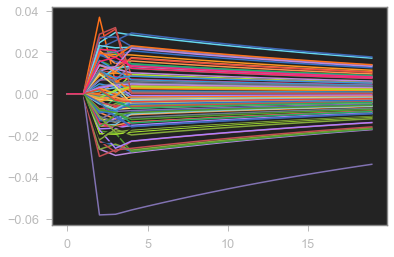

In [10]:
plt.plot( (v.detach().numpy() )[0,:,:] )

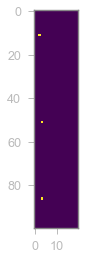

In [11]:
plt.imshow( z[0].detach().numpy().T )

In [9]:
#### SINGLE TRAIN EPOCH, FOR DEBUGGING ####

# Example of forward pass with the LIF neuron module
state = cell.zero_state(input_spikes.size(0), dtype=dtype)
z, v = [], []
for t in range( input_spikes.size(1) ):
    out, state = cell( input_spikes[:,t], state )
    z.append(state.z); v.append(state.v)
z = torch.stack(z, dim=1)
v = torch.stack(v, dim=1)

# output loss
#w_out = torch.nn.Parameter( torch.randn( params['n_rec'], params['n_out'] )/np.sqrt( params['n_rec'] ) ).type(dtype=dtype)
w_out = torch.nn.Parameter( torch.from_numpy( w_out_tf ).type(dtype=dtype) )
output_current = torch.einsum('bti,ik->btk', z, w_out)
#readout_decay = torch.tensor( np.exp(-params['dt'] / params['tau_m_readout']) ).item()
readout_decay = np.exp(-params['dt'] / params['tau_m_readout'])
output = exp_convolve(output_current, decay=readout_decay)
output_error = output - target_sinusoidal_outputs
loss = 0.5 * torch.sum(output_error ** 2)

# regularization loss
av = torch.mean(z, dim=(0, 1)) / params['dt']
average_firing_rate_error = av - regularization_f0
loss_reg = 0.5 * torch.sum(average_firing_rate_error ** 2)

overall_loss = loss_reg * params['reg'] + loss

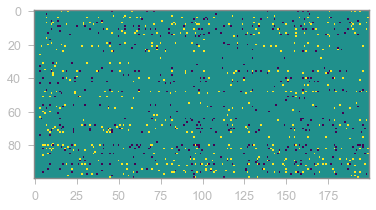

In [10]:
plt.imshow( (z.detach().numpy() - z_tf )[0].T )

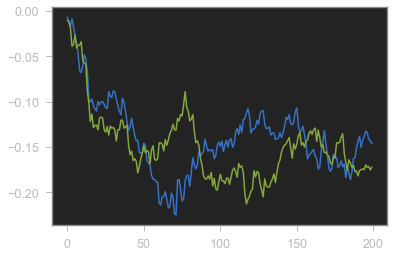

In [11]:
plt.plot( (v.detach().numpy() )[0,:,10] )
#plt.plot( (v_debug.detach().numpy() )[0,:,10] )
plt.plot( (results_values['v'])[0,:,10] )

In [31]:
step = 10
#i_t = torch.matmul(input_spikes[:,0], cell.w_in_var) + torch.matmul(z, cell.w_rec_val)
i_t = torch.matmul(input_spikes[:,step], torch.from_numpy(w_in_tf) ) +\
                    torch.matmul( torch.from_numpy(z_tf[:,step]), torch.from_numpy(w_rec_tf))
I_reset = z_tf[:,step] * cell.thr * cell.dt
new_v = cell._decay * torch.from_numpy( v_tf[:,step] ) + (1 - cell._decay) * i_t - I_reset

In [15]:
step = 10
#i_t = torch.matmul(input_spikes[:,0], cell.w_in_var) + torch.matmul(z, cell.w_rec_val)
i_t = np.matmul(input_spikes[:,step].numpy(), w_in_tf ) +\
                    np.matmul( z_tf[:,step], w_rec_tf)
I_reset = z_tf[:,step] * cell.thr * cell.dt
new_v = cell._decay * v_tf[:,step] + (1 - cell._decay) * i_t - I_reset

In [39]:
new_v

tensor([[-4.6894e-03,  3.7195e-02,  6.9393e-03, -2.0843e-02, -1.8184e-02,
         -9.9876e-02, -2.2407e-03, -5.3176e-03,  1.0205e-02,  1.9278e-02,
         -2.4406e-02, -4.9991e-02,  2.5563e-02,  4.8250e-03,  2.1126e-02,
         -2.0951e-02, -5.0277e-02, -2.6995e-02,  6.0940e-03,  2.7407e-02,
         -1.7779e-02, -1.8323e-02, -2.9501e-02, -1.9322e-02, -1.9585e-02,
         -1.5214e-02, -1.0188e-02, -2.3413e-02, -9.5680e-03,  1.5768e-02,
         -4.4856e-03,  1.0472e-03, -3.7813e-02,  3.5304e-02, -5.0469e-02,
          1.3569e-02,  2.2103e-02, -3.7871e-02, -8.5376e-03, -2.0247e-02,
          8.3008e-03,  4.1119e-02, -1.6585e-02, -4.6734e-02,  1.1474e-02,
         -1.8615e-02, -6.3829e-03, -3.9262e-02,  2.9194e-02, -1.1114e-02,
         -4.7451e-02, -1.4623e-03, -1.7111e-02, -1.9373e-02, -2.9780e-02,
         -2.5968e-03, -2.3296e-02,  2.0810e-02, -1.9561e-02, -1.3886e-03,
         -5.4683e-02,  2.2398e-02, -1.9343e-02,  6.7585e-03,  1.8247e-02,
         -5.3504e-03, -1.9437e-02,  1.

In [43]:
v[0,12,:]

tensor([ 1.7059e-03,  1.4715e-02,  1.1870e-02, -1.5590e-02, -2.3000e-02,
        -1.0137e-01, -9.3711e-03, -1.4098e-04,  1.1163e-02,  1.1213e-02,
        -2.4604e-02, -4.9738e-02,  1.6602e-02,  1.6919e-02,  7.4000e-03,
        -1.8618e-02, -2.5754e-02, -3.9453e-02, -3.7497e-04,  2.0360e-02,
        -2.1962e-02, -2.9712e-02, -2.7124e-02, -1.7661e-02, -2.0157e-02,
        -3.5535e-02, -1.5735e-03, -3.0245e-02, -1.2150e-02,  2.6098e-02,
        -3.0656e-02,  1.4652e-02, -2.0750e-02,  1.5951e-02, -3.6381e-02,
        -2.1896e-02, -5.4641e-03, -2.9266e-02, -1.1818e-02,  5.3981e-03,
        -3.4422e-03,  3.2575e-03, -1.7819e-02, -2.6613e-02,  9.4127e-03,
         1.3076e-03, -9.2326e-04, -3.2657e-02,  2.2401e-02,  3.9253e-03,
        -1.8603e-02,  1.3193e-02, -1.4376e-02, -1.0043e-02, -2.5529e-02,
         8.2373e-06, -1.7380e-02,  3.1174e-03, -2.9231e-02,  5.3627e-03,
        -5.3329e-02,  1.5647e-02, -5.0843e-03, -4.3976e-04,  7.7370e-03,
         2.6471e-03, -9.9291e-04,  1.8277e-02,  7.5

In [16]:
v_tf[:,11]

array([[-0.02020015,  0.00278748, -0.03191763,  0.0014757 , -0.00451339,
         0.03160568,  0.02662695, -0.02178719,  0.0360561 ,  0.01076357,
        -0.06799572,  0.01739101, -0.00467109, -0.00172029,  0.02257215,
         0.02277338,  0.00224667,  0.01926322,  0.00767958, -0.00136794,
         0.02769976,  0.00028316,  0.01460229,  0.01179325, -0.00594553,
        -0.01431212, -0.01541983, -0.00562325,  0.00567976, -0.03647922,
        -0.03444003, -0.01703587,  0.00111038, -0.0111174 , -0.00461997,
         0.01602479, -0.04465773,  0.00016909,  0.01280602,  0.00429158,
        -0.00579798,  0.01946513,  0.0391281 ,  0.03299217,  0.01175382,
         0.01816658,  0.02549778,  0.01010099,  0.01678701,  0.00721347,
         0.00244893,  0.0207422 , -0.0181583 , -0.003602  , -0.04260161,
        -0.043531  ,  0.02187997, -0.02826129, -0.02002527,  0.00557713,
         0.00746153,  0.01006613,  0.00090048, -0.03594401,  0.00963006,
         0.02148823,  0.00758114,  0.00378199, -0.0

In [111]:
new_v[0,0] - v_tf[:,11,0]

tensor([0.0053])

Initial Loss: 0.1897


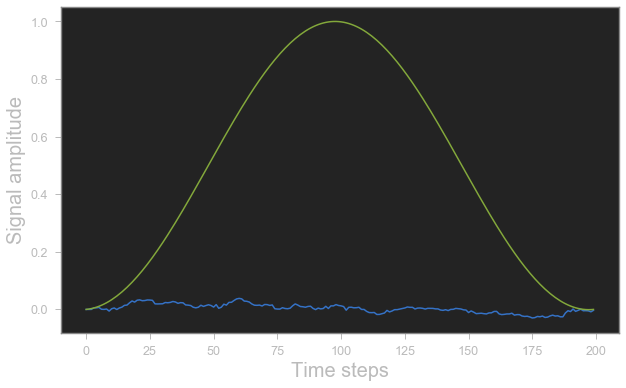

In [12]:
plt.figure('signals', (10,6))
plt.plot( output[0].detach().numpy() )
plt.plot( target_sinusoidal_outputs[0].detach().numpy() )
plt.xlabel( 'Time steps',size=20 )
plt.ylabel( 'Signal amplitude',size=20 )
print( 'Initial Loss: {:.4f}'.format( compute_loss( z, w_out, target_sinusoidal_outputs )[0] ) )

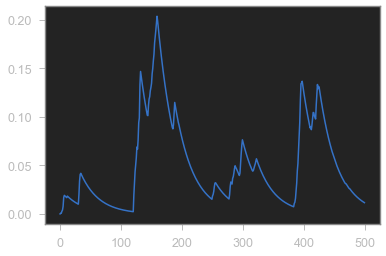

In [17]:
plt.plot( eligibility_traces_convolved_w_in.detach().numpy()[0,:,0,1] )

In [73]:
def pseudo_derivative(v_scaled, dampening_factor):
    '''
    Define the pseudo derivative used to derive through spikes.
    :param v_scaled: scaled version of the voltage being 0 at threshold and -1 at rest
    :param dampening_factor: parameter that stabilizes learning
    :return:
    '''
    return torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0)) * dampening_factor

In [95]:
post_term = pseudo_derivative(torch.from_numpy(results_values['v_scaled']), params['dampening_factor']) / params['thr'] 

In [96]:
torch.sum( post_term - results_values['post_term'] )

tensor(-0.0009)

In [85]:
np.where( post_term - results_values['post_term'] )

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([  0,   0,   0, ..., 199, 199, 199], dtype=int64),
 array([ 7, 29, 30, ..., 72, 94, 96], dtype=int64))

In [88]:
post_term[0,0,7].item() , results_values['post_term'][0,0,7]

(0.9630782008171082, 0.96307826)

In [17]:
torch.tensor(decay).item() - cell._decay

-2.601530058043977e-08

In [18]:
torch.tensor(decay) - cell._decay

tensor(0.)

In [19]:
pre_term_w_in_item = exp_convolve(input_spikes, decay=torch.tensor(decay).item())

In [97]:
torch.sum( pre_term_w_in_item - results_values['pre_term_w_in'] )

tensor(0.)

In [98]:
torch.sum( pre_term_w_rec - results_values['pre_term_w_rec'] )

tensor(0.)

In [39]:
torch.sum( pre_term_w_out - results_values['pre_term_w_out'] )

tensor(0.)

In [99]:
torch.sum( post_term - results_values['post_term'] )

tensor(-0.0009)

In [106]:
torch.sum( eligibility_traces_w_in - results_values['eligibility_traces_w_in'] )

tensor(-0.0040)

In [107]:
torch.sum( eligibility_traces_w_rec - results_values['eligibility_traces_w_rec'] )

tensor(-0.0019)

In [108]:
torch.sum( eligibility_traces_convolved_w_in - results_values['eligibility_traces_convolved_w_in'] )

tensor(-0.0033)

In [109]:
torch.sum( eligibility_traces_convolved_w_rec - results_values['eligibility_traces_convolved_w_rec'] )

tensor(-0.0016)

In [110]:
torch.sum( learning_signals - results_values['learning_signals'] )

tensor(0.)

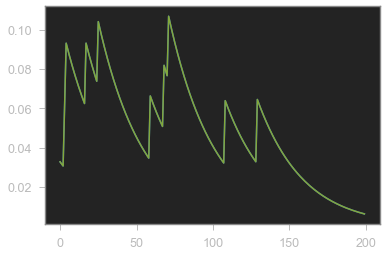

In [28]:
plt.plot( pre_term_w_in.detach().numpy()[0,:,0] )
plt.plot( results_values['pre_term_w_in'][0,:,0] )

In [105]:
##### This is the Pytorch graph computed over tensorflow results

# Calculation of the Elegibility Trace
v_scaled = (results_values['v'] - params['thr']) / params['thr'] # voltage scaled to be 0 at threshold and -1 at rest
post_term = pseudo_derivative(torch.from_numpy(results_values['v_scaled']), params['dampening_factor']) / params['thr'] # non-linear function of the voltage
#post_term = torch.from_numpy(results_values['post_term'])
z_previous_time = shift_by_one_time_step(torch.from_numpy(results_values['z'])) # z(t-1) instead of z(t)

pre_term_w_in = exp_convolve(input_spikes, decay=torch.tensor(decay).item())
pre_term_w_rec = exp_convolve(z_previous_time, decay=torch.tensor(decay).item())
pre_term_w_out = exp_convolve(torch.from_numpy(results_values['z']), decay=torch.tensor(decay).item())

# for PCMprop develop next lines
#pre_term_w_in = pcm_convolve(input_spikes, nu)
#pre_term_w_rec = pcm_convolve(z_previous_time, nu)
#pre_term_w_out = pcm_convolve(z, nu)

eligibility_traces_w_in = post_term[:, :, None, :] * pre_term_w_in[:, :, :, None]
eligibility_traces_w_rec = post_term[:, :, None, :] * pre_term_w_rec[:, :, :, None]

# To define the gradient of the readout error,
# the eligibility traces are smoothed with the same filter as the readout
eligibility_traces_convolved_w_in = exp_convolve(eligibility_traces_w_in, decay=readout_decay)
eligibility_traces_convolved_w_rec = exp_convolve(eligibility_traces_w_rec, decay=readout_decay)

# To define the gradient of the regularization error defined on the averaged firing rate,
# the eligibility traces should be averaged over time
eligibility_traces_averaged_w_in = torch.mean(eligibility_traces_w_in, dim=(0, 1))
eligibility_traces_averaged_w_rec = torch.mean(eligibility_traces_w_rec, dim=(0, 1))


B_random = torch.from_numpy(results_values['w_out']) # better performance is obtained with the true error feed-backs
output_error = torch.from_numpy(results_values['output']) - target_sinusoidal_outputs
learning_signals = torch.einsum('btk,jk->btj', output_error, B_random)

# gradients of the main loss with respect to the weights
dloss_dw_out = torch.sum(output_error[:, :, None, :] * pre_term_w_out[:, :, :, None], dim=(0, 1))
dloss_dw_in = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_in, dim=(0, 1))
dloss_dw_rec = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_rec, dim=(0, 1))

# gradients of the regularization loss with respect to the weights
dreg_loss_dw_in = torch.from_numpy(results_values['average_firing_rate_error']) * eligibility_traces_averaged_w_in
dreg_loss_dw_rec = torch.from_numpy(results_values['average_firing_rate_error']) * eligibility_traces_averaged_w_rec

# combine the gradients
dloss_dw_in += dreg_loss_dw_in * params['reg']
dloss_dw_rec += dreg_loss_dw_rec * params['reg']

# Somewhat important detail: self connection are disabled therefore gradients on the diagonal are zeros
mask_autotapse = torch.diag(torch.ones(params['n_rec'])).bool()
dloss_dw_rec = torch.where(mask_autotapse, torch.zeros_like(dloss_dw_rec), dloss_dw_rec)

# put the resulting gradients into lists
var_list = [cell.w_in_var, cell.w_rec_var, w_out]
true_gradients = torch.autograd.grad(overall_loss, var_list, retain_graph=True)
eprop_gradients = [dloss_dw_in, dloss_dw_rec, dloss_dw_out]

# performing the weight update
#with torch.no_grad():
#    for n, var in enumerate(var_list): 
#        var -= params['learning_rate'] * eprop_gradients[n]

In [91]:
np.sum(true_grads_np_out - eprop_gradients[2].detach().numpy())

0.00015638769

In [92]:
np.sum(true_grads_np_rec - eprop_gradients[1].detach().numpy())

-1.987206e-05

In [93]:
np.sum(true_grads_np_in - eprop_gradients[0].detach().numpy())

-0.00016979314

In [58]:
# Calculation of the Elegibility Trace
v_scaled = (v - params['thr']) / params['thr'] # voltage scaled to be 0 at threshold and -1 at rest
post_term = pseudo_derivative(v_scaled, params['dampening_factor']) / params['thr'] # non-linear function of the voltage
z_previous_time = shift_by_one_time_step(z) # z(t-1) instead of z(t)

pre_term_w_in = exp_convolve(input_spikes, decay=torch.tensor(decay).item())
pre_term_w_rec = exp_convolve(z_previous_time, decay=torch.tensor(decay).item())
pre_term_w_out = exp_convolve(z, decay=torch.tensor(decay).item())

# for PCMprop develop next lines
#pre_term_w_in = pcm_convolve(input_spikes, nu)
#pre_term_w_rec = pcm_convolve(z_previous_time, nu)
#pre_term_w_out = pcm_convolve(z, nu)

eligibility_traces_w_in = post_term[:, :, None, :] * pre_term_w_in[:, :, :, None]
eligibility_traces_w_rec = post_term[:, :, None, :] * pre_term_w_rec[:, :, :, None]

# To define the gradient of the readout error,
# the eligibility traces are smoothed with the same filter as the readout
eligibility_traces_convolved_w_in = exp_convolve(eligibility_traces_w_in, decay=readout_decay)
eligibility_traces_convolved_w_rec = exp_convolve(eligibility_traces_w_rec, decay=readout_decay)

# To define the gradient of the regularization error defined on the averaged firing rate,
# the eligibility traces should be averaged over time
eligibility_traces_averaged_w_in = torch.mean(eligibility_traces_w_in, dim=(0, 1))
eligibility_traces_averaged_w_rec = torch.mean(eligibility_traces_w_rec, dim=(0, 1))

if params['random_feedback']:
    B_random = torch.from_numpy(np.random.randn(params['n_rec'], params['n_out']) / np.sqrt(params['n_rec']) ).type(dtype=dtype)
else:
    B_random = w_out.clone() # better performance is obtained with the true error feed-backs
learning_signals = torch.einsum('btk,jk->btj', output_error, B_random)

# gradients of the main loss with respect to the weights
dloss_dw_out = torch.sum(output_error[:, :, None, :] * pre_term_w_out[:, :, :, None], dim=(0, 1))
dloss_dw_in = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_in, dim=(0, 1))
dloss_dw_rec = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_rec, dim=(0, 1))

# gradients of the regularization loss with respect to the weights
dreg_loss_dw_in = average_firing_rate_error * eligibility_traces_averaged_w_in
dreg_loss_dw_rec = average_firing_rate_error * eligibility_traces_averaged_w_rec

# combine the gradients
dloss_dw_in += dreg_loss_dw_in * params['reg']
dloss_dw_rec += dreg_loss_dw_rec * params['reg']

# Somewhat important detail: self connection are disabled therefore gradients on the diagonal are zeros
mask_autotapse = torch.diag(torch.ones(params['n_rec'])).bool()
dloss_dw_rec = torch.where(mask_autotapse, torch.zeros_like(dloss_dw_rec), dloss_dw_rec)

# put the resulting gradients into lists
var_list = [cell.w_in_var, cell.w_rec_var, w_out]
true_gradients = torch.autograd.grad(overall_loss, var_list, retain_graph=True)
eprop_gradients = [dloss_dw_in, dloss_dw_rec, dloss_dw_out]

# performing the weight update
#with torch.no_grad():
#    for n, var in enumerate(var_list): 
#        var -= params['learning_rate'] * eprop_gradients[n]

In [59]:
torch.sum( true_gradients[0] - eprop_gradients[0] )

tensor(-8430.7236, grad_fn=<SumBackward0>)

In [60]:
torch.sum( true_gradients[1] - eprop_gradients[1] )

tensor(-4079.9082, grad_fn=<SumBackward0>)

In [61]:
torch.sum( true_gradients[2] - eprop_gradients[2] )

tensor(225.7521, grad_fn=<SumBackward0>)

In [35]:
dloss_dw_out/ (dw_out+1e-12)

NameError: name 'dw_out' is not defined

In [44]:
eprop_gradients[2] / (true_gradients[2]+1e-12)

tensor([[202.4128],
        [204.5433],
        [196.0178],
        [216.2755],
        [  0.0000],
        [214.6801],
        [206.4326],
        [  0.0000],
        [198.5385],
        [213.7240],
        [202.9833],
        [205.7735],
        [152.7896],
        [211.6492],
        [  0.0000],
        [  0.0000],
        [208.4000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [211.4648],
        [195.7058],
        [196.7012],
        [202.4102],
        [198.8755],
        [207.7237],
        [206.0452],
        [207.8608],
        [220.2620],
        [211.1163],
        [  0.0000],
        [153.7349],
        [218.6583],
        [  0.0000],
        [203.9365],
        [211.5282],
        [  0.0000],
        [196.4719],
        [221.6388],
        [196.8865],
        [148.9655],
        [  0.0000],
        [200.8723],
        [146.9386],
        [212.5110],
        [276.1340],
        [208.9384],
        [  0.0000],


In [154]:
dw_out = torch.autograd.grad( loss, w_out, retain_graph=True )[0]

In [162]:
# This is the analytical expression for dw_out
dw_out_ = torch.mean( torch.abs( target_sinusoidal_outputs - output )*z, dim=(0,1) )/2

# Learning Loop

In [170]:
params['eprop_or_bptt'] = 'eprop'
params['stop_z_gradients'] = True
params['random_feedback'] = False
params['learning_rate'] = 0.0005

cell = LightLIF(n_in=params['n_in'], n_rec=params['n_rec'], tau=tau_m, thr=thr, dt=dt,
                dampening_factor=params['dampening_factor'],
                stop_z_gradients=params['stop_z_gradients'])

w_out = torch.nn.Parameter( torch.randn( params['n_rec'], params['n_out'] )
                           /np.sqrt( params['n_rec'] ) ).type(dtype=dtype)


In [177]:
loss_hist = []
t_train = 0
for k_iter in range(100):
    # train
    t0 = time()
    z, v = forward( input_spikes )
    overall_loss, average_firing_rate_error, output_error, output = compute_loss( z, w_out, target_sinusoidal_outputs )
    loss_hist.append( overall_loss.item() )
    if params['eprop_or_bptt'] == 'bptt':
        gradients, var_list = calculate_true_gradient(overall_loss)
    elif params['eprop_or_bptt'] == 'eprop':
        gradients, var_list = calculate_eligibility_trace(v,z, output_error, average_firing_rate_error)
    elif params['eprop_or_bptt'] == 'pcmprop':
        gradients, var_list = calculate_eligibility_trace_pcm(v,z, output_error, average_firing_rate_error )
    weight_update_SGD( gradients, var_list )
    t_train = time() - t0

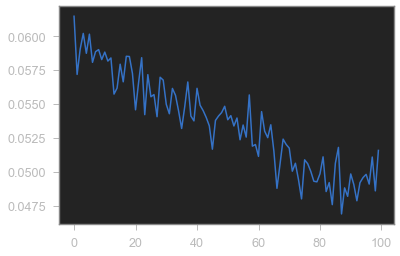

In [178]:
plt.plot( loss_hist )

Loss: 0.0500


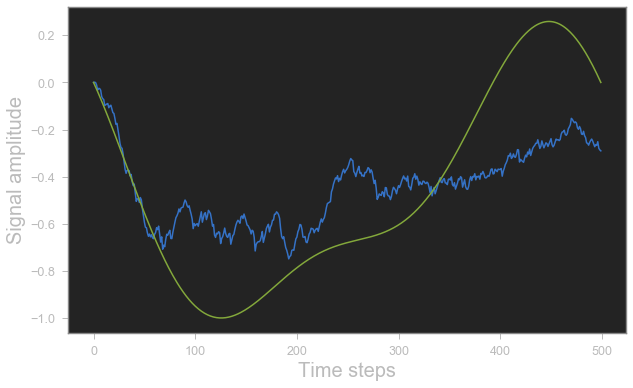

In [179]:
z, v = forward( input_spikes )
output_current = torch.einsum('bti,ik->btk', z, w_out)
output = exp_convolve(output_current, decay=readout_decay)

plt.figure('signals', (10,6))
plt.plot( output[0].detach().numpy() )
plt.plot( target_sinusoidal_outputs[0].detach().numpy() )
plt.xlabel( 'Time steps',size=20 )
plt.ylabel( 'Signal amplitude',size=20 )
print( 'Loss: {:.4f}'.format( compute_loss( z, w_out, target_sinusoidal_outputs )[0] ) )

# Learning loop with interactive plot

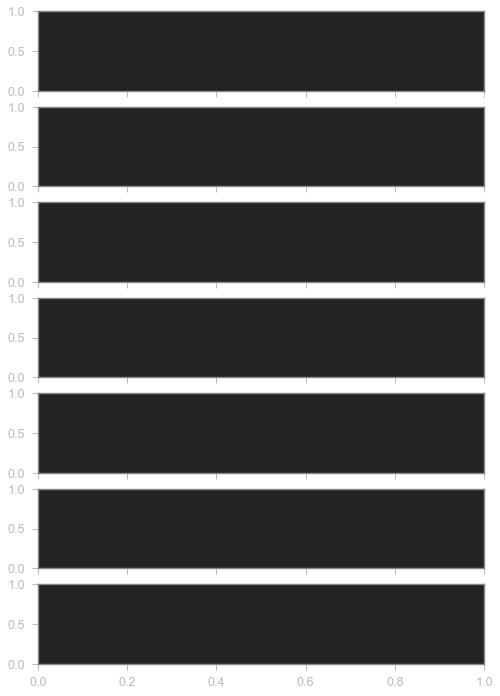

In [25]:
# Open an interactive matplotlib window to plot in real time
if params['do_plot']:
    plt.ion()
    fig, ax_list = plt.subplots(2 + params['n_out'] + 4, figsize=(8, 12), sharex=True)

In [26]:
def update_plot(plot_result_values, batch=0, n_max_neuron_per_raster=40):
    """
    This function iterates the matplotlib figure on every call.
    It plots the data for a fixed sequence that should be representative of the expected computation
    :return:
    """

    # Clear the axis to print new plots
    for k in range(ax_list.shape[0]):
        ax = ax_list[k]
        ax.clear()

    # PLOT Input signals
    for k, spike_ref in enumerate(['input_spikes', 'z']):
        spikes = plot_result_values[spike_ref][batch]

        spikes = spikes[:, :n_max_neuron_per_raster]
        ax = ax_list[k]

        ax.imshow(spikes.T, aspect='auto', cmap='hot_r')
        ax.set_xlim([0, FLAGS.seq_len])
        ax.set_ylabel(spike_ref)

    output = plot_result_values['output'][batch]
    for i in range(output.shape[1]):
        ax = ax_list[i + 2]
        ax.set_yticks([-1, 0, 1])
        # ax.set_ylim([-1., 1.])
        ax.set_ylabel('Output')

        ax.plot(np.arange(FLAGS.seq_len), target_sinusoidal_outputs[batch, :, i], linestyle='dashed', label='Target',
                alpha=0.8)
        ax.plot(np.arange(FLAGS.seq_len), output[:, i], linestyle='solid', label='Target', alpha=0.8)

        ax.set_xlim([0, FLAGS.seq_len])

    el_data_list = []
    i_pre = j_post = 0
    while i_pre == j_post or np.all(el_data_list[2] == 0):
        # choose i and j to find an interesting synapse representative of what is happening
        i_pre = np.random.randint(FLAGS.n_rec)
        j_post = np.random.randint(FLAGS.n_rec)
        el_data_list = [results_values['pre_term'][batch, :, i_pre],
                        results_values['post_term'][batch, :, j_post],
                        results_values['eligibility_traces'][batch, :, i_pre, j_post],
                        results_values['learning_signals'][batch, :, j_post],
                        ]

    name_list = ['term pre',
                 'term post',
                 'eligibility trace',
                 'learning signal']

    for k, name, data in zip(range(len(name_list)), name_list, el_data_list):
        ax = ax_list[2 + FLAGS.n_out + k]
        ax.plot(np.arange(FLAGS.seq_len), data)
        ax.set_xlim([0, FLAGS.seq_len])
        ax.set_ylabel(name)

    ax_list[2 + n_out + 0].set_ylim([0, 0.25])
    ax_list[2 + n_out + 1].set_ylim([0, 10.])
    ax_list[2 + n_out + 2].set_ylim([0, 1.])
    ax_list[2 + n_out + 3].set_ylim([-0.08, 0.08])

    ax.set_xlabel('Time in ms')
    # To plot with interactive python one need to wait one second to the time to draw the axis
    if do_plot:
        plt.draw()
        plt.pause(0.1)

In [ ]:
# Loss list to store the loss over itertaions
loss_list = []
t_train = 0
for k_iter in range(n_iter):

    # train
    t0 = time()
    # optimizer.zero_grad()
    z, v = forward( input_spikes )
    w_out = torch.nn.Parameter( torch.randn( n_rec, n_out )/np.sqrt( n_rec ) ).type(dtype=dtype)
    overall_loss = compute_loss( w_out, target_sinusoidal_outputs )
    if params['eprop_or_bptt'] == 'bptt':
        gradients, var_list = calculate_true_gradient(overall_loss)
    elif params['eprop_or_bptt'] == 'eprop':
        gradients, var_list = calculate_eligibility_trace(overall_loss)
    elif params['eprop_or_bptt'] == 'pcmprop':
        gradients, var_list = calculate_eligibility_trace_pcm(overall_loss)
    weight_update_SGD( gradients, var_list )
    t_train = time() - t0

    if np.mod(k_iter, print_every) == 0:

        if gradient_check:
            if not (stop_z_gradients):
                print('Gradient check is disabled because the gradients of inter neuron dependencies are not blocked.')
            elif seq_len > 20:
                print('Gradient check is disabled for sequence lengths larger than 20 time steps')
            else:
                print('Gradient check')
                eprop_grads_np, true_grads_np = sess.run([eprop_gradients, true_gradients])
                check_gradients(var_list, eprop_grads_np, true_grads_np)

        print('''Iteration {}, loss {:.3g} reg loss {:.3g}'''.format(k_iter, results_values['loss'],
                                                                     results_values['loss_reg']))
        loss_list.append(results_values['loss'])

        def get_stats(v):
            if np.size(v) == 0:
                return np.nan, np.nan, np.nan, np.nan
            min_val = np.min(v)
            max_val = np.max(v)

            k_min = np.sum(v == min_val)
            k_max = np.sum(v == max_val)

            return np.min(v), np.max(v), np.mean(v), np.std(v), k_min, k_max


        firing_rate_stats = get_stats(results_values['av'] * 1000)

        print('''
            firing rate (Hz)  min {:.0f} \t max {:.0f} \t average {:.0f} +- std {:.0f} (averaged over batches and time)
            comput. time (s)  training {:.2g} \t validation {:.2g}'''.format(
            firing_rate_stats[0], firing_rate_stats[1], firing_rate_stats[2], firing_rate_stats[3],
            t_train, t_valid,
        ))

        if do_plot:
            update_plot(results_values)

plt.ioff()
update_plot(results_values)

fig, ax_res = plt.subplots()
ax_res.plot(loss_list)
ax_res.set_xlabel('iterations')
ax_res.set_ylabel('mean square error')

plt.show()

In [ ]:
results_tensors = {
    'loss': loss,
    'loss_reg': loss_reg,
    'overall_loss': overall_loss,

    'input_spikes': input_spikes,
    'z': z,
    'av': av,

    'pre_term': pre_term_w_rec,
    'post_term': post_term,
    'eligibility_traces': eligibility_traces_convolved_w_rec,
    'learning_signals': learning_signals,

    'output': output,
}